Удаление существующей папки: 'images/benchmark/distorted'...
Создана новая папка: 'images/benchmark/distorted'
Создана новая папка: 'images/benchmark/ground_truth_filters'
Найдено изображений для обработки: 53

--- Сохранение ядер в виде изображений ---
  -> Сохранено ядро: images/benchmark/ground_truth_filters\defocusgaussian.png
  -> Сохранено ядро: images/benchmark/ground_truth_filters\defocusdisk.png
  -> Сохранено ядро: images/benchmark/ground_truth_filters\defocuscone.png
  -> Сохранено ядро: images/benchmark/ground_truth_filters\defocusring.png
  -> Сохранено ядро: images/benchmark/ground_truth_filters\motionlinearuniform.png
  -> Сохранено ядро: images/benchmark/ground_truth_filters\motionlinearexp.png
  -> Сохранено ядро: images/benchmark/ground_truth_filters\motionbsplinesimplecurve.png
  -> Сохранено ядро: images/benchmark/ground_truth_filters\motionbsplinecurlcurve.png
  -> Сохранено ядро: images/benchmark/ground_truth_filters\motionbsplineloop.png
  -> Сохранено ядро: imag

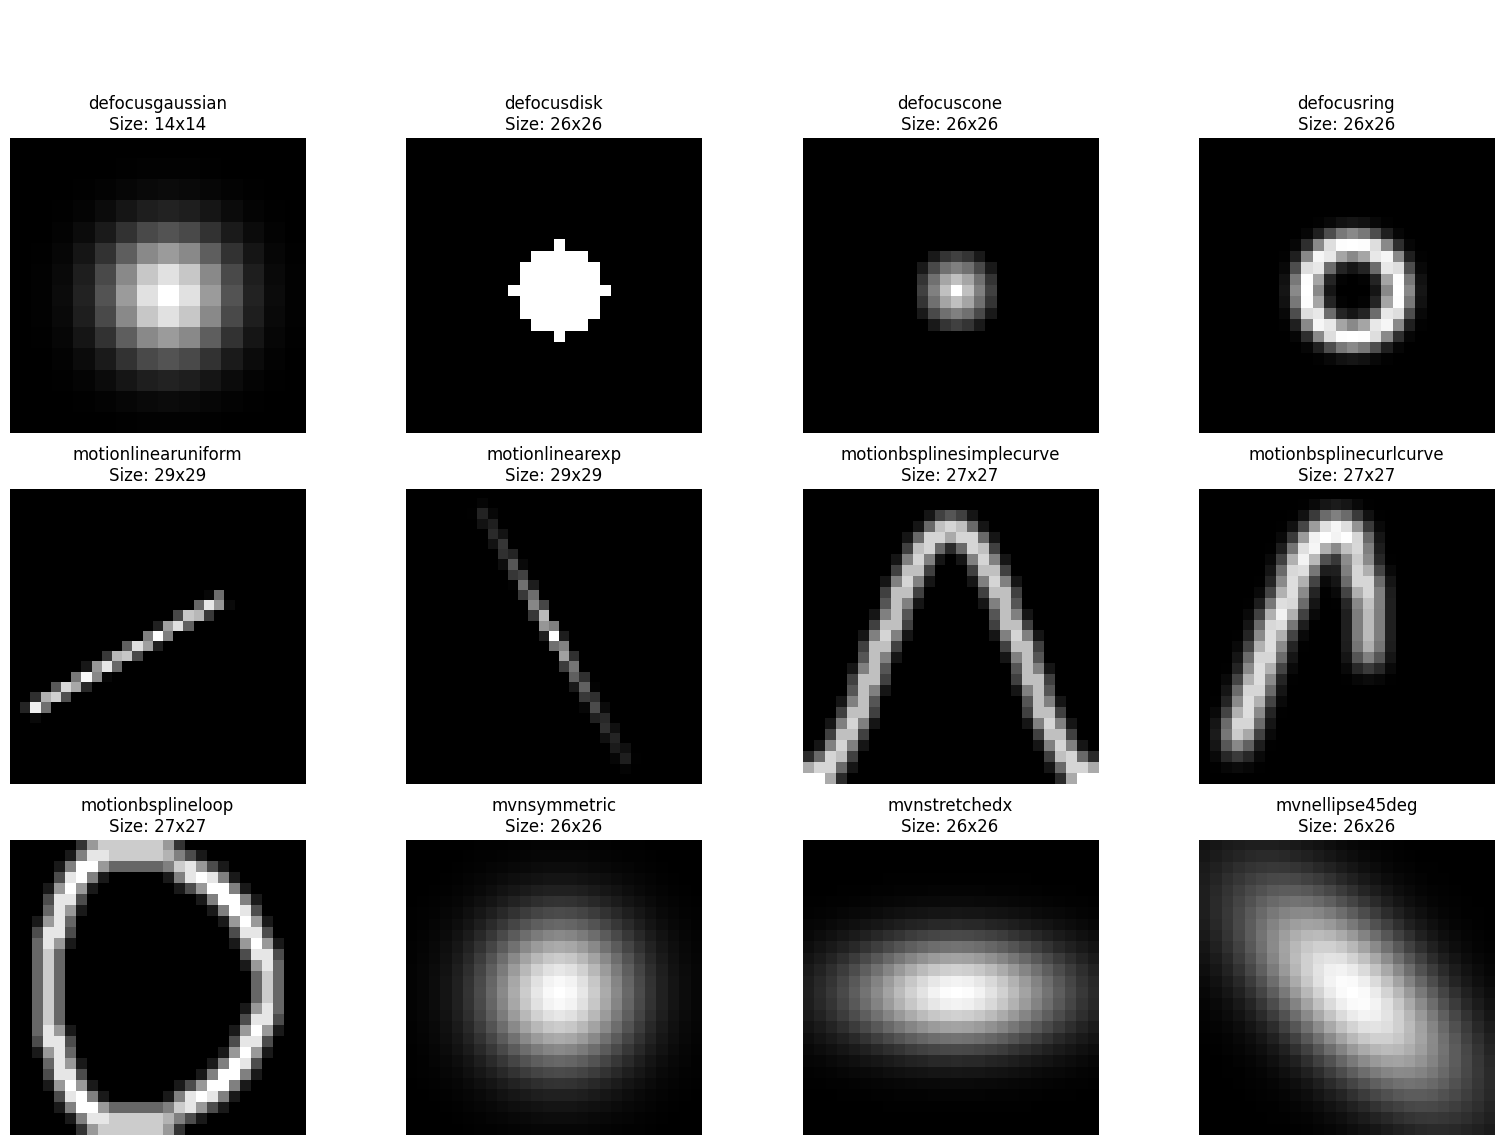


--- Обработка изображения: 41069.png ---
  -> Сохранено: images/benchmark/distorted\41069_defocusgaussian.png
  -> Сохранено: images/benchmark/distorted\41069_defocusgaussian_gaussian.png
  -> Сохранено: images/benchmark/distorted\41069_defocusgaussian_poisson.png
  -> Сохранено: images/benchmark/distorted\41069_defocusgaussian_saltpepper.png
  -> Сохранено: images/benchmark/distorted\41069_defocusdisk.png
  -> Сохранено: images/benchmark/distorted\41069_defocusdisk_gaussian.png
  -> Сохранено: images/benchmark/distorted\41069_defocusdisk_poisson.png
  -> Сохранено: images/benchmark/distorted\41069_defocusdisk_saltpepper.png
  -> Сохранено: images/benchmark/distorted\41069_defocuscone.png
  -> Сохранено: images/benchmark/distorted\41069_defocuscone_gaussian.png
  -> Сохранено: images/benchmark/distorted\41069_defocuscone_poisson.png
  -> Сохранено: images/benchmark/distorted\41069_defocuscone_saltpepper.png
  -> Сохранено: images/benchmark/distorted\41069_defocusring.png
  -> Сохранен

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import shutil
import math
from typing import Tuple
from scipy.stats import multivariate_normal

from filters.blur import *
from filters.distributions import *
from filters.noise import *

class ImageFilterProcessor:
    def __init__(self, input_dir='images/benchmark/original', output_dir='images/benchmark/distorted', kernel_dir='images/benchmark/ground_truth_filters'):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.kernel_dir = kernel_dir
        self.kernel_ksize = 26

        self.blur_configs = [
            {'name': 'defocusgaussian', 'class': DefocusBlur, 'params': {'psf': gaussian_distribution, 'param': 2.0}},
            {'name': 'defocusdisk', 'class': DefocusBlur, 'params': {'psf': uniform_distribution, 'param': 4.0}},
            {'name': 'defocuscone', 'class': DefocusBlur, 'params': {'psf': linear_decay_distribution, 'param': 4.0}},
            {'name': 'defocusring', 'class': DefocusBlur, 'params': {'psf': ring_distribution, 'param': 4.0}},
            {'name': 'motionlinearuniform', 'class': MotionBlur, 'params': {'psf': uniform_distribution, 'param': 7.0, 'angle': 30}},
            {'name': 'motionlinearexp', 'class': MotionBlur, 'params': {'psf': exponential_decay_distribution, 'param': 7.0, 'angle': 120}},
            {
                'name': 'motionbsplinesimplecurve', 
                'generator_func': generate_bspline_motion_kernel, 
                'params': {
                    'ksize': self.kernel_ksize, 
                    'thickness': 3,
                    # Контрольные точки для простой S-образной кривой
                    'points': [(-20, -10), (-10, 10), (0, -10), (10, 10), (20, -10)]
                }
            },
            {
                'name': 'motionbsplinecurlcurve', 
                'generator_func': generate_bspline_motion_kernel, 
                'params': {
                    'ksize': self.kernel_ksize, 
                    'thickness': 5,
                    # Загогулинка
                    'points': [(-10, 10), (0, -10), (2, 2)]
                }
            },
        
            {
                'name': 'motionbsplineloop', 
                'generator_func': generate_bspline_motion_kernel, 
                'params': {
                    'ksize': self.kernel_ksize, 
                    'thickness': 3,
                    # Точки для создания петли
                    'points': [(-10, 0), (0, 12), (10, 0), (0, -12), (-10, 0)]
                }
            },
            {
                'name': 'mvnsymmetric', 
                #'generator_func': self._generate_multivariate_normal_kernel, 
                'generator_func': generate_multivariate_normal_kernel, 
                'params': {'ksize': self.kernel_ksize, 'cov': [[20.0, 0.0], [0.0, 20.0]]}
            },
            {
                'name': 'mvnstretchedx', 
                'generator_func': generate_multivariate_normal_kernel, 
                'params': {'ksize': self.kernel_ksize, 'cov': [[40.0, 0.0], [0.0, 10.0]]}
            },
            {
                'name': 'mvnellipse45deg', 
                'generator_func': generate_multivariate_normal_kernel, 
                'params': {'ksize': self.kernel_ksize, 'cov': [[40.0, 25.0], [25.0, 40.0]]}
            },

            

        ]

        self.noise_configs = [
            {'name': 'gaussian', 'class': GaussianNoise, 'params': {'param': 6.0}},
            {'name': 'poisson', 'class': PoissonNoise, 'params': {'param': 0.05}},
            {'name': 'saltpepper', 'class': SaltAndPepperNoise, 'params': {'param': (1, 1, 2000)}}
        ]

    #@staticmethod
    

    def _apply_all_filters(self, image: np.ndarray) -> Tuple[dict, dict]:
        results, kernels = {}, {}

        for blur_config in self.blur_configs:
            blur_name = blur_config['name']
            
            if 'generator_func' in blur_config:
                kernel = blur_config['generator_func'](**blur_config['params'])
                # --- ИСПРАВЛЕНИЕ ЗДЕСЬ ---
                class GenericFilter(FilterBase):
                    def __init__(self, k):
                        super().__init__(None, 'blur')
                        self.k = k
                    def generate_kernel(self): return self.k
                    def filter(self, img): return cv2.filter2D(img, -1, self.k)
                    def discription(self) -> str: return "Generic Filter" # Реализуем недостающий метод
                blur_filter = GenericFilter(kernel)

            elif 'class' in blur_config:
                blur_filter = blur_config['class'](**blur_config['params'])
                kernel = blur_filter.generate_kernel()
            else:
                continue

            kernels[blur_name] = (kernel, f"{blur_name}\nSize: {kernel.shape[0]}x{kernel.shape[1]}")
            blurred_image = blur_filter.filter(image)
            results[blur_name] = blurred_image

            for noise_config in self.noise_configs:
                noise_name = noise_config['name']
                noise_filter = noise_config['class'](**noise_config['params'])
                noisy_image = noise_filter.filter(blurred_image)
                final_name = f"{blur_name}_{noise_name}"
                results[final_name] = noisy_image
            
        return results, kernels

    def _show_plot(self, kernels: dict):
        kernel_items = list(kernels.items())
        num_kernels = len(kernel_items)
        cols = 4
        rows = math.ceil(num_kernels / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        plt.style.use('dark_background')
        fig.suptitle('Сгенерированные ядра размытия', fontsize=16)
        axes = axes.flatten()

        for i, (name, (kernel, description)) in enumerate(kernel_items):
            axes[i].imshow(kernel, cmap='gray')
            axes[i].set_title(description)
            axes[i].axis('off')

        for i in range(num_kernels, len(axes)):
            axes[i].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def _save_kernels(self, kernels: dict):
        print("\n--- Сохранение ядер в виде изображений ---")
        for name, (kernel, _) in kernels.items():
            if np.max(kernel) > 0:
                kernel_img = (kernel / np.max(kernel)) * 255
            else:
                kernel_img = kernel
            kernel_img = kernel_img.astype(np.uint8)
            output_path = os.path.join(self.kernel_dir, f"{name}.png")
            cv2.imwrite(output_path, kernel_img)
            print(f"  -> Сохранено ядро: {output_path}")

    def process_images(self):
        for directory in [self.output_dir, self.kernel_dir]:
            if os.path.exists(directory):
                print(f"Удаление существующей папки: '{directory}'...")
                shutil.rmtree(directory)
            os.makedirs(directory)
            print(f"Создана новая папка: '{directory}'")

        image_paths = glob.glob(os.path.join(self.input_dir, '*.[pP][nN][gG]')) + \
                      glob.glob(os.path.join(self.input_dir, '*.[jJ][pP][gG]')) + \
                      glob.glob(os.path.join(self.input_dir, '*.[jJ][pP][eE][gG]'))
        if not image_paths:
            print(f"Ошибка: Не найдено изображений в папке '{self.input_dir}'.")
            return
        print(f"Найдено изображений для обработки: {len(image_paths)}")

        dummy_image = np.zeros((100, 100, 3), dtype=np.uint8)
        _, kernels_for_plot = self._apply_all_filters(dummy_image)
        self._save_kernels(kernels_for_plot)
        print("\nОтображение всех сгенерированных ядер...")
        self._show_plot(kernels_for_plot)
        
        for image_path in image_paths:
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            print(f"\n--- Обработка изображения: {os.path.basename(image_path)} ---")
            
            image = cv2.imread(image_path)
            if image is None:
                print(f"Не удалось прочитать изображение: {image_path}. Пропускаю.")
                continue
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # original_path = os.path.join(self.output_dir, f"{base_name}_original.png")
            # cv2.imwrite(original_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
            # print(f"  -> Сохранено: {original_path}")

            filtered_results, _ = self._apply_all_filters(image_rgb)
            
            for filter_name, result_image in filtered_results.items():
                output_filename = f"{base_name}_{filter_name}.png"
                output_path = os.path.join(self.output_dir, output_filename)
                result_image_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(output_path, result_image_bgr)
                print(f"  -> Сохранено: {output_path}")

        print("\nОбработка всех изображений завершена.")




processor = ImageFilterProcessor()
processor.process_images()